In [1]:
from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [0]:
# declare imports and functions

import json
import numpy as np
from matplotlib import pyplot as plt

def get_match_for_pos_neg(truth, pred, truth_state=True, match=True):
    all_state_pos = np.where(truth == 1)[0] if truth_state else np.where(truth == 0)[0]
    count = 0
    for v in all_state_pos:
        if match and pred[v] == truth[v]:
            count += 1
        elif not match and pred[v] != truth[v]:
            count += 1
    return count


def get_pos_neg_results_from_threshold(y_pred, y, value_type, threshold):
    diff = 0.5 - threshold
    y_pred_new = np.round(np.clip(np.add(np.asarray(y_pred), diff), a_min=0, a_max=1))
    if value_type == 'true pos':
        value = get_match_for_pos_neg(truth=y, pred=y_pred_new, truth_state=True, match=True)
    elif value_type == 'true neg':
        value = get_match_for_pos_neg(truth=y, pred=y_pred_new, truth_state=False, match=True)
    elif value_type == 'false pos':
        value = get_match_for_pos_neg(truth=y, pred=y_pred_new, truth_state=False, match=False)
    elif value_type == 'false neg':
        value = get_match_for_pos_neg(truth=y, pred=y_pred_new, truth_state=True, match=False)
    return value


def get_precision(y_pred, y, threshold):
    true_pos = get_pos_neg_results_from_threshold(y_pred=y_pred, y=y, value_type='true pos', threshold=threshold)
    false_pos = get_pos_neg_results_from_threshold(y_pred=y_pred, y=y, value_type='false pos', threshold=threshold)
    return true_pos / (true_pos + false_pos)  # given all pred pos


def get_recall(y_pred, y, threshold):
    true_pos = get_pos_neg_results_from_threshold(y_pred=y_pred, y=y, value_type='true pos', threshold=threshold)
    false_neg = get_pos_neg_results_from_threshold(y_pred=y_pred, y=y, value_type='false neg', threshold=threshold)
    return true_pos / (true_pos + false_neg)  # given all ground truth pos



In [0]:
# start running data structuring process

with open("drive/My Drive/Colab Notebooks/Sephora/predictions_and_labels.json") as f:
    data = json.load(f)

thresholds = np.arange(0.0, 1, 0.05)
results_threshold = {}

y_truth = data['Y']
data['Y_pred'] = np.asarray(data['Y_pred'])
# one hot encoding
y_truth_one_hot = np.zeros_like(data['Y_pred'])
for i, v in enumerate(y_truth):
    if v != []:
        for e in v:
            y_truth_one_hot[i][e - 1] = 1

label_results = []
for i in range(3):
    # label wise information
    tpos, tneg, fpos, fneg, precision, recall = [], [], [], [], [], []
    for t in thresholds:
        tpos.append(get_pos_neg_results_from_threshold(y_pred=data['Y_pred'][:, i], y=y_truth_one_hot[:, i],
                                                       value_type='true pos', threshold=t))
        tneg.append(get_pos_neg_results_from_threshold(y_pred=data['Y_pred'][:, i], y=y_truth_one_hot[:, i],
                                                       value_type='true neg', threshold=t))
        fpos.append(get_pos_neg_results_from_threshold(y_pred=data['Y_pred'][:, i], y=y_truth_one_hot[:, i],
                                                       value_type='false pos', threshold=t))
        fneg.append(get_pos_neg_results_from_threshold(y_pred=data['Y_pred'][:, i], y=y_truth_one_hot[:, i],
                                                       value_type='false neg', threshold=t))
        precision.append(get_precision(y_pred=data['Y_pred'][:, i], y=y_truth_one_hot[:, i], threshold=t))
        recall.append(get_recall(y_pred=data['Y_pred'][:, i], y=y_truth_one_hot[:, i], threshold=t))

    label_results.append({'true pos': tpos, 'true neg': tneg, 'false pos': fpos, 'false neg': fneg,
                        'precision': precision, 'recall': recall})

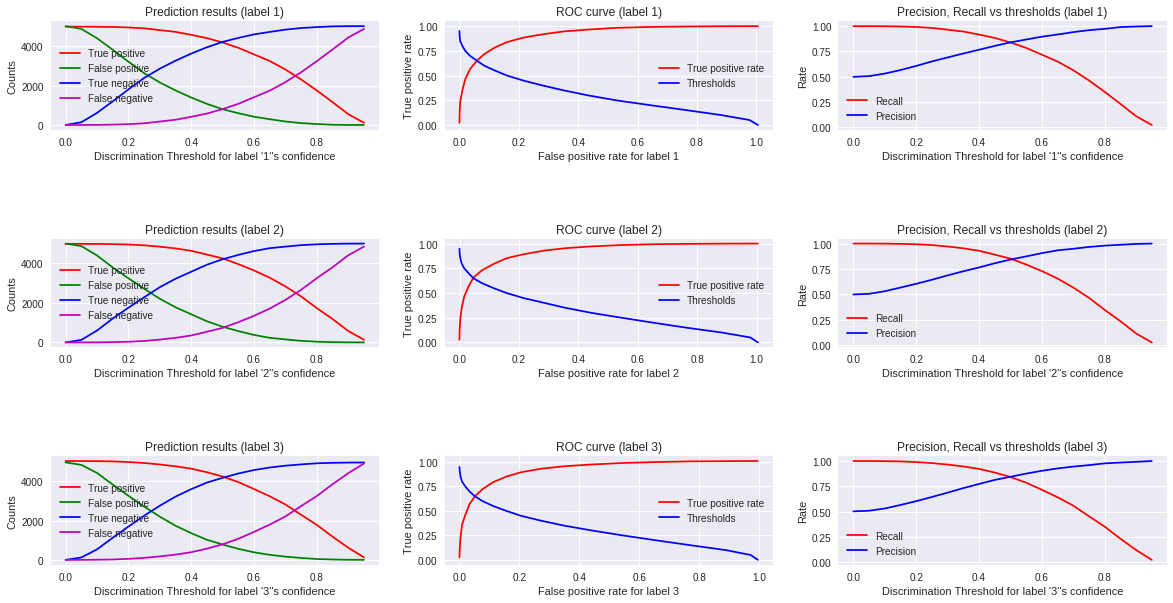

In [4]:
plt.rcParams['figure.figsize'] = [20, 10]

plt.subplots_adjust(wspace=None, hspace=1)
for i,l in enumerate(label_results):
    label_true_pos = np.asarray([results_threshold[x][i]['true pos'] for x in results_threshold])
    label_true_neg = np.asarray([results_threshold[x][i]['true neg'] for x in results_threshold])
    label_false_pos = np.asarray([results_threshold[x][i]['false pos'] for x in results_threshold])
    label_false_neg = np.asarray([results_threshold[x][i]['false neg'] for x in results_threshold])

    label_precision = label_true_pos / (label_true_pos + label_false_pos)  # given all pred pos
    label_recall = label_true_pos / (label_true_pos + label_false_neg)  # given all ground truth pos

    ax1 = plt.subplot2grid((3, 3), loc=(i, 0), colspan=1)
    ax2 = plt.subplot2grid((3, 3), (i, 1), colspan=1)
    ax3 = plt.subplot2grid((3, 3), (i, 2), colspan=1)

    ax1.set_ylabel('Counts')
    ax1.set_xlabel("Discrimination Threshold for label '" + str(i + 1) + "''s confidence")
    ax1.plot(thresholds, l['true pos'], 'r', label='True positive')
    ax1.plot(thresholds, l['false pos'], 'g', label='False positive')
    ax1.plot(thresholds, l['true neg'], 'b', label='True negative')
    ax1.plot(thresholds, l['false neg'], 'm', label='False negative')
    ax1.set_title("Prediction results (label " + str(i + 1) + ")")
    ax1.legend()

    ground_pos_cnt = np.sum(y_truth_one_hot[:,0])
    ax2.set_ylabel('True positive rate')
    ax2.set_xlabel('False positive rate for label '+ str(i + 1))
    ax2.plot(l['false pos'] / ground_pos_cnt, l['true pos'] / ground_pos_cnt, 'r',
             label='True positive rate')
    ax2.plot(l['false pos'] / ground_pos_cnt, thresholds, 'b', label='Thresholds')
    ax2.set_title("ROC curve (label " + str(i + 1) + ")")
    ax2.legend()

    ax3.set_ylabel('Rate')
    ax3.set_xlabel("Discrimination Threshold for label '" + str(i + 1) + "''s confidence")
    ax3.plot(thresholds, l['recall'], 'r', label='Recall')
    ax3.plot(thresholds, l['precision'], 'b', label='Precision')
    ax3.set_title("Precision, Recall vs thresholds (label " + str(i + 1) + ")")
    ax3.legend()

'\nIndeed the curve profiles for the 3 labels,(1,2,3) are very similar, so top graphs are expected.\n\n'

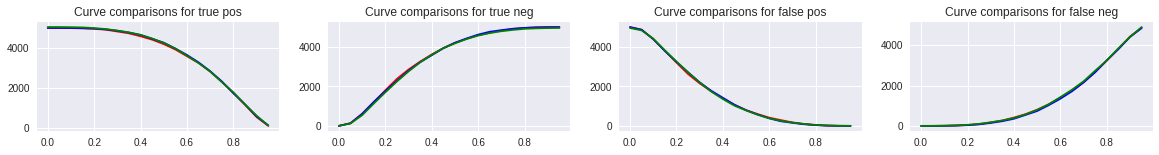

In [5]:
'''
for testing purposes, to ensure that the data for each class are correctly read and not copies of each other because the 
graphs above look too alike
'''
plt.subplots_adjust(wspace=None, hspace=1)
    
result_keys = ['true pos','true neg','false pos','false neg'];
axes = [plt.subplot2grid((3, 4), (0, i), colspan=1) for i,v in enumerate(result_keys)]
color=['r','b','g','m']

for i,v in enumerate(result_keys):
  for j,l in enumerate(label_results):
    axes[i].plot(thresholds,l[v], color[j], label='Label '+str(i+1))
    axes[i].set_title("Curve comparisons for "+v)
    
'''
Indeed the curve profiles for the 3 labels,(1,2,3) are very similar, so top graphs are expected.

'''
   

Ground truth positive count: 56
Pred true>0.6: 49
TRUE Pred true>0.6: 42
TRUE Pred true>0.6: 42


Text(0.5, 1.0, 'Data points')

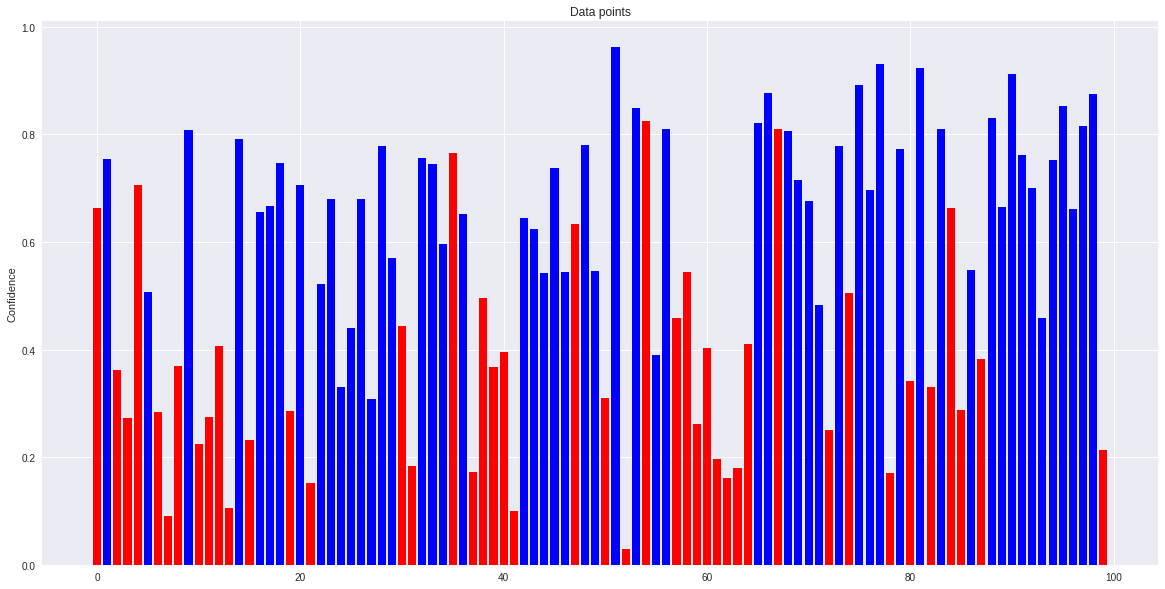

In [6]:
'''Working for Qn1'''
limit=100

subarr_y_pred=[x[0] for x in data['Y_pred'][:limit]]
subarr_y_truth = y_truth_one_hot[:,0][:limit]
subarr_combined = [[v,subarr_y_truth[i]] for i,v in enumerate(subarr_y_pred)]

colors=['b' if x == 1 else 'r'  for x in subarr_y_truth]

plt.bar(np.arange(limit), subarr_y_pred, align='center',color=colors)

number_of_ground_truth_positives = len(list(filter(lambda x:x=='b',colors)))
print('Ground truth positive count:',number_of_ground_truth_positives)
print('Pred true>0.6:',str(len(list(filter(lambda x:x[0]>0.6,subarr_combined)))))
print('TRUE Pred true>0.6:',str(len(list(filter(lambda x:x[0]>0.6 and x[1]==1,subarr_combined)))))
print('TRUE Pred true>0.6:',str(len(list(filter(lambda x:x[0]>0.6 and x[1]==1,subarr_combined)))))

plt.ylabel('Confidence')
plt.title('Data points')

# blue means the ground truth equivalent for the data point is positive
# red means the ground truth equivalent for the data point is negative

In [0]:
'''Answers for qn 2 and 3'''
def threshold_optimizer(y_pred, y, key, limit, t=[0, 1]):
    _s = lambda threshold, type: get_pos_neg_results_from_threshold(y_pred, y, value_type=type, threshold=threshold)

    demon = np.sum(y) if key.__contains__('pos') else len(y) - np.sum(y)
    t = [t[0], (t[0] + t[1]) / 2, t[1]]
    if key.__contains__('pos') or key == 'recall':  # decreasing relationship
        key_rate = [_s(x, 'true pos') / (_s(x, 'true pos') + _s(x, 'false neg')) for x in
                    t] if key == 'recall' else [_s(x, key) / demon for x in t]
        if key_rate[0] > limit and limit > key_rate[1]:
            t[2] = (t[2] + t[1]) / 2
        elif key_rate[1] > limit and limit > key_rate[2]:
            t[0] = (t[1] + t[0]) / 2
    elif key.__contains__('neg') or key == 'precision':  # increasing relationship

        key_rate = [_s(x, 'true pos') / (_s(x, 'true pos') + _s(x, 'false pos')) for x in
                    t] if key == 'precision' else [_s(x, key) / demon for x in t]
        if key_rate[0] < limit and limit < key_rate[1]:
            t[2] = (t[2] + t[1]) / 2
        elif key_rate[1] < limit and limit < key_rate[2]:
            t[0] = (t[1] + t[0]) / 2

    if t[2] - t[0] < 0.00001:
        return t[1]
    return threshold_optimizer(y_pred, y, key, limit, t=[t[0], t[2]])



false_pos_20_thresholds = []
recall_80_thresholds = []
for label in range(3):
    false_pos_20_thresholds.append(threshold_optimizer(y_pred=[x[label] for x in data['Y_pred']],
                                                       y=y_truth_one_hot[:, label], key='false pos', limit=0.2))
    recall_80_thresholds.append(threshold_optimizer(y_pred=[x[label] for x in data['Y_pred']],
                                                    y=y_truth_one_hot[:, label], key='recall', limit=0.8))

true_pos_at_false_pos_20 = [
    get_pos_neg_results_from_threshold(y_pred=data['Y_pred'][:, i], y=y_truth_one_hot[:, i], value_type='true pos',
                                       threshold=v) / np.sum(y_truth_one_hot[:, i]) for i, v in
    enumerate(false_pos_20_thresholds)]
precision_at_recall_80 = [get_precision(y_pred=data['Y_pred'][:, i], y=y_truth_one_hot[:, i], threshold=v) for i, v in
                          enumerate(recall_80_thresholds)]

import pandas as pd

qn2_results = pd.DataFrame(
    {'label': [1, 2, 3], 'Minimum threshold at maximum 0.2 false positive rate': false_pos_20_thresholds,
     'Minimum true positive rate at maximum 0.2 false positive rate': true_pos_at_false_pos_20})
qn3_results = pd.DataFrame({'label': [1, 2, 3], 'Maximum threshold at minimum 0.8 recall': recall_80_thresholds,
                            'Maximum precision at minimum 0.8 recall': precision_at_recall_80})

In [8]:
qn2_results


,Minimum threshold at maximum 0.2 false positive rate,Minimum true positive rate at maximum 0.2 false positive rate,label
0,0.461875,0.872468,1
1,0.463665,0.880633,2
2,0.453081,0.883661,3


In [9]:
qn3_results


,Maximum precision at minimum 0.8 recall,Maximum threshold at minimum 0.8 recall,label
0,0.861369,0.536455,1
1,0.870560,0.544426,2
2,0.870598,0.539088,3
